In [2]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
import matplotlib.pyplot as plt

In [3]:
suffixes = ["held_out", "test", "train", "validation"]


base_path= "/mimer/NOBACKUP/groups/naiss2023-6-290/erngard/REINVENT4_MasterThesis/dataset/tack"
dataframes = []
for suffix in suffixes:
    try:
        csv_file = f"{base_path}_{suffix}.smi"
        dataframes.append(pd.read_csv(csv_file, header=None, names=["SMILES"]))
    except Exception as e:
        print(e)
        continue


df = pd.DataFrame()
df = pd.concat(dataframes, ignore_index=True)




#count = df.count("PROTACDB ID")
display(df)
print(df.columns)
#counts = df.groupby(["E3 Ligase", "Target"]).count().sort_values("PROTACDB ID", ascending=False)
#display(counts)


[Errno 2] No such file or directory: '/mimer/NOBACKUP/groups/naiss2023-6-290/erngard/REINVENT4_MasterThesis/dataset/tack_held_out.smi'
[Errno 2] No such file or directory: '/mimer/NOBACKUP/groups/naiss2023-6-290/erngard/REINVENT4_MasterThesis/dataset/tack_test.smi'


,SMILES
0,CC(C)(O)c1cc2nn(C3CCN(CC(=O)N4CCN(c5ccc6c(c5)C...
1,C#Cc1cccc2cc(O)cc(-c3ncc4c(N5CC6CCC(C5)N6)nc(O...
2,C#Cc1cccc2cc(O)cc(-c3ncc4c(N5CC6CCC(C5)N6)nc(O...
3,CC(C)(C)c1noc(C(=O)NCc2ccc(-c3ncnc4[nH]c(-c5cn...
4,N#Cc1ccc(N2CCC(c3ccc(N4CCC(CN5CCN(c6ccn7c(=O)n...
...,...
7690,Cc1ncsc1-c1ccc(CNC(=O)[C@@H]2C[C@@H](O)CN2C(=O...
7691,Cc1ncsc1-c1ccc(CNC(=O)[C@@H]2C[C@@H](O)CN2C(=O...
7692,Cc1ncsc1-c1ccc(CNC(=O)[C@@H]2C[C@@H](O)CN2C(=O...
7693,Cc1ncsc1-c1ccc(CNC(=O)[C@@H]2C[C@@H](O)CN2C(=O...


Index(['SMILES'], dtype='object')


In [8]:
base_path = "/mimer/NOBACKUP/groups/naiss2023-6-290/erngard/REINVENT4_MasterThesis/dataset/synthetic"

# for all files and suffixes, check how many rows include F OR S

for suffix in suffixes:
    try:
        csv_file = f"{base_path}_{suffix}.smi"
        df = pd.read_csv(csv_file, header=None, names=["SMILES"])
        count_f = df["SMILES"].str.contains("[C@@H]").sum()
        count_s = df["SMILES"].str.contains("%11").sum()
        print(f"{suffix}: F count = {count_f}, S count = {count_s}")
    except Exception as e:
        print(e)
        continue

held_out: F count = 5670, S count = 9
test: F count = 11296, S count = 13
train: F count = 1297604, S count = 974
validation: F count = 11315, S count = 19


In [14]:
smiles_list = df["SMILES"]



desc_fns = {
    "Length"      : len,
    "MolWt"       : Descriptors.MolWt,
    "LogP"        : Descriptors.MolLogP,
    "TPSA"        : Descriptors.TPSA,
    "HBA"         : Descriptors.NumHAcceptors,
    "HBD"         : Descriptors.NumHDonors,
    "RotBonds"    : Descriptors.NumRotatableBonds,
}

smiles_props = pd.DataFrame(columns=list(desc_fns.keys()))

print(smiles_props)

for i, smi in enumerate(smiles_list):
    row = []
    mol = Chem.MolFromSmiles(smi)
    row.append(len(smi))
    for name, desc in desc_fns.items():
        if name != "Length":
            row.append(desc(mol))
    
    smiles_props.loc[i] = row


#for col in smiles_props.columns:


Empty DataFrame
Columns: [Length, MolWt, LogP, TPSA, HBA, HBD, RotBonds]
Index: []


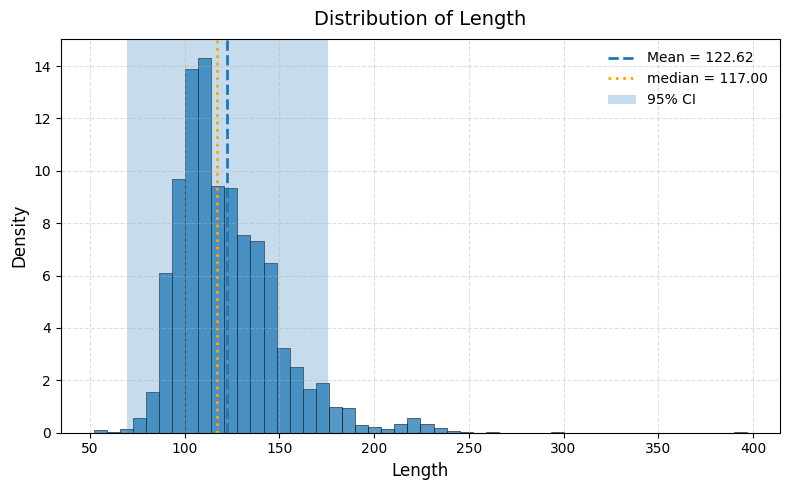

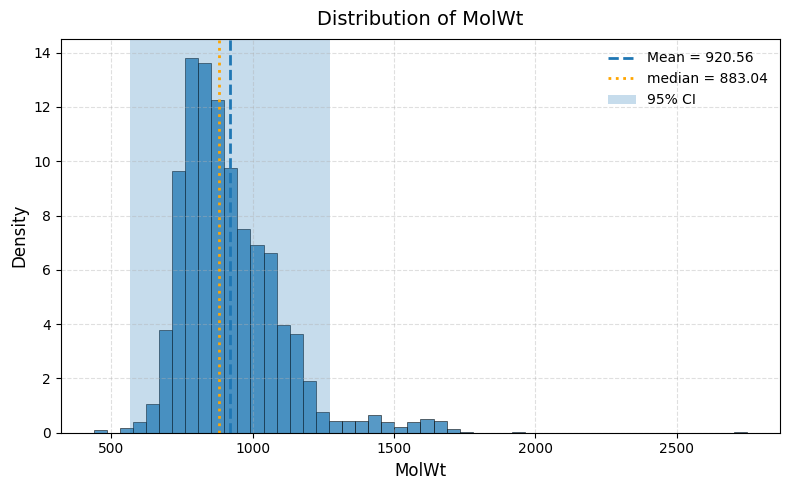

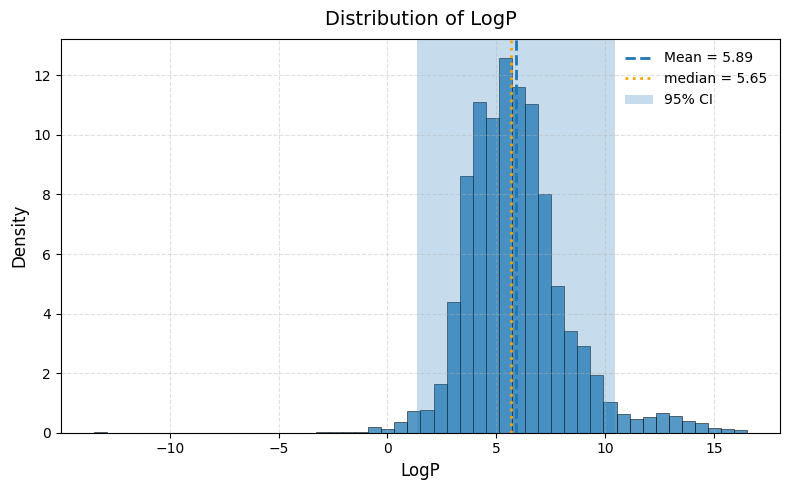

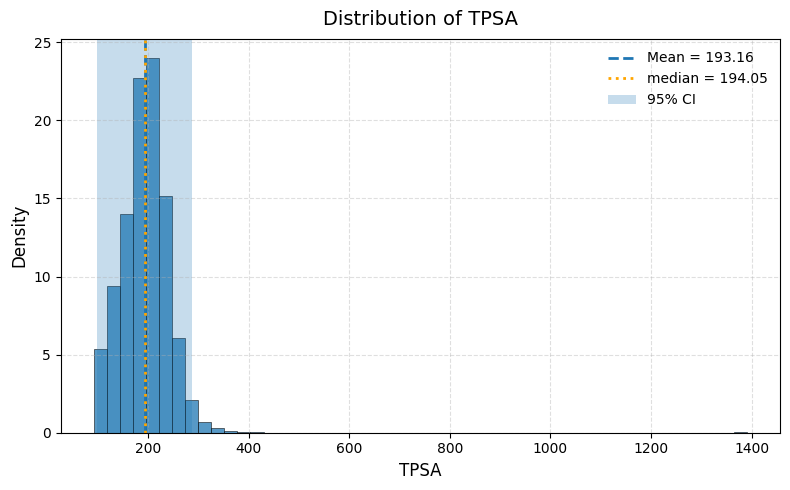

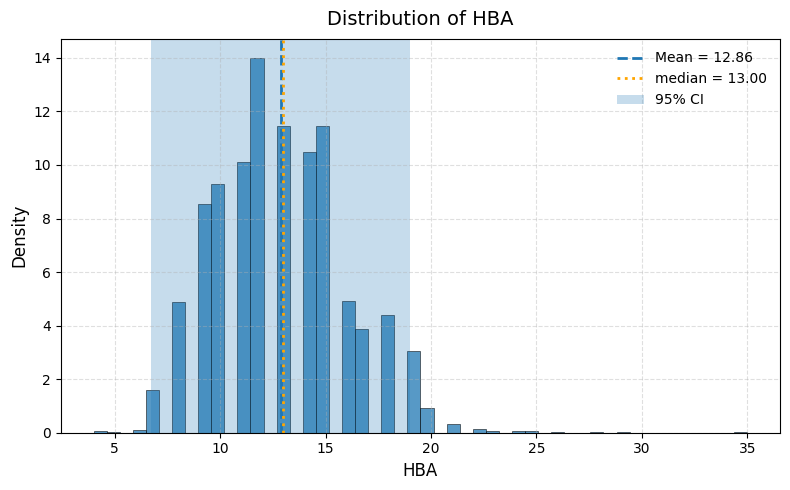

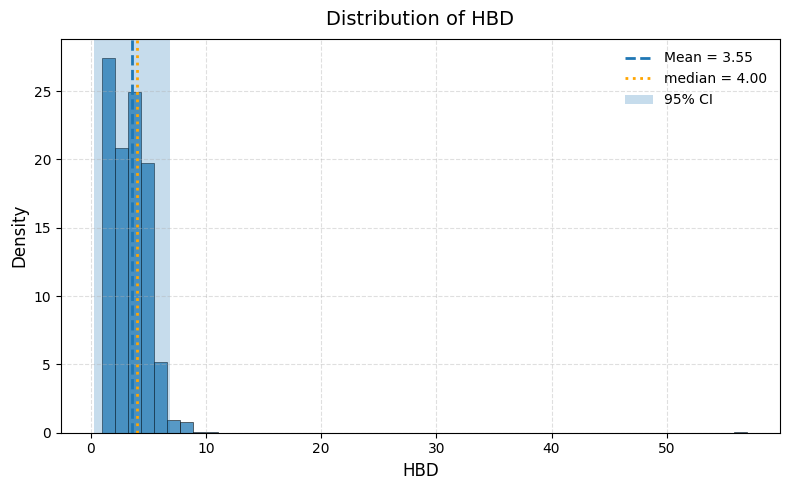

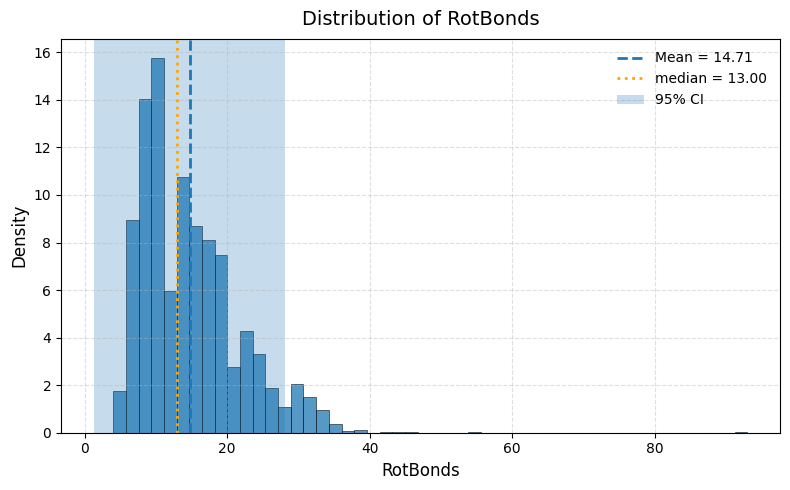

,max,min,mean,median,std,Lower bound,Upper bound
Length,397.00000,52.00000,122.622352,117.00000,27.076825,69.551774,175.692930
MolWt,2750.27400,437.88300,920.562072,883.03900,180.794084,566.205668,1274.918476
LogP,16.51926,-13.49256,5.892387,5.65158,2.322245,1.340788,10.443987
TPSA,1391.19000,91.95000,193.163862,194.05000,48.560126,97.986015,288.341710
HBA,35.00000,4.00000,12.864327,13.00000,3.137445,6.714935,19.013720
HBD,57.00000,1.00000,3.546589,4.00000,1.690162,0.233871,6.859306
RotBonds,93.00000,4.00000,14.711761,13.00000,6.864244,1.257843,28.165679


In [16]:
import matplotlib.pyplot as plt
import numpy as np

stats_df = smiles_props.agg(['max', 'min', 'mean', 'median', 'std']).T

for col in smiles_props.columns:
    data = smiles_props[col].dropna()

    mean = stats_df.loc[col, 'mean']
    std = stats_df.loc[col, 'std']
    median = stats_df.loc[col, 'median']

    sigma = 1.96

    lb = mean - sigma * std
    ub = mean + sigma * std

    stats_df.loc[col, "Lower bound"] = lb
    stats_df.loc[col, "Upper bound"] = ub

    plt.figure(figsize=(8, 5))
    percentage = np.ones_like(data) * 100 / len(data)

    plt.hist(
        data,
        bins=50,
        weights=percentage,
        alpha=0.75,
        edgecolor='black',
        linewidth=0.5
    )

    plt.axvline(
        mean,
        linestyle='--',
        linewidth=2,
        label=f"Mean = {mean:.2f}"
    )

    plt.axvline(
        median,
        linestyle='dotted',
        linewidth=2,
        label=f"median = {median:.2f}",
        color = "orange"
    )

    plt.axvspan(
        lb,
        ub,
        alpha=0.25,
        label="95% CI"
    )

    plt.title(f"Distribution of {col}", fontsize=14, pad=10)
    plt.xlabel(col, fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.legend(frameon=False)

    plt.tight_layout()
    plt.show()

display(stats_df)
